## Problema e Objetivo

Imagine que um cliente faça uma compra de um item como, por exemplo, computador ou celular. O item é devidamente entregue, mas o usuário afirma que não. Como podemos garantir a entrega do produto?

Vocês deverão utilizar Optical Character Recognition (OCR) para garantir que a assinatura feita durante a entrega de um determinado produto é semelhante à assinatura de um documento pessoal do mesmo cliente.

In [ ]:
#Instalando dependencias
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install unidecode

In [ ]:
#Importando pacotes e bibliotecas
import os
import pytesseract
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from unidecode import unidecode
from numpy import random
try:
  from PIL import Image, ImageChops, ImageStat
except ImportError:
  import Image
from google.colab import files
from google.colab.patches import cv2_imshow
import zipfile
import seaborn as sns

In [ ]:
df = pd.read_excel("table_nomeFraude.xlsx")
risco = 0

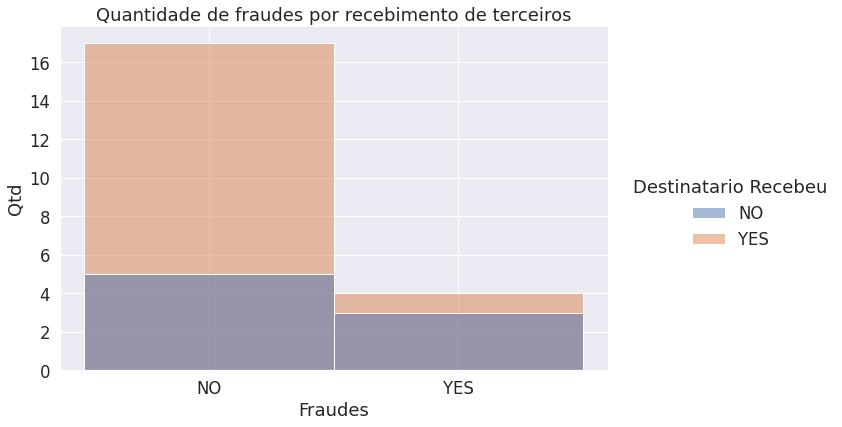

In [ ]:
sns.set(font_scale = 1.5)
gra = sns.displot(df, x="Fraude", hue="Destinatario Recebeu", height=6, aspect=1.5)
gra.set(xlabel = "Fraudes", ylabel = "Qtd", title = "Quantidade de fraudes por recebimento de terceiros")

Analisando um grafico do nosso dataframe conseguimos perceber que a maioria das fraudes está ligado quando outra pessoa recebe a mercadoria, pensando nisso resolvemos fazer a seguintes resoluções.

*   Verificar se a assinatura do remetente corresponde ao de quem fez o pedido
*   Verificar e calcular a diferença da digital


#Metodo 01 - Assinatura

In [ ]:
try:
  nome = input("Digite o nome do remetente: ")
except:
  print("Erro ao inserir o nome")

In [ ]:
try:
  print("Assinatura de recebimento")
  assinatura = files.upload()
  for i in assinatura.keys():
        print('Arquivo "{nome}" tamanho {tamanho} bytes'.format(nome=i, tamanho=len(assinatura[i])))
        ass = i
except:
  print("Erro no upload de imagem")

In [ ]:
#Faremos uma simples verificação de segurança da imagem enviada
try:
  ass_zip = zipfile.ZipFile("ass_zip.zip", "w")
  ass_zip.write(ass, compress_type=zipfile.ZIP_DEFLATED)
  ass_zip.close()
  ass_unzip = zipfile.ZipFile("ass_zip.zip")
  ass_unzip.extractall("./Imagens")
  ass_unzip.close()
  dire = "./" + ass
  os.remove(dire)
  assinatura = "Imagens/" + ass
except:
  print("Erro na verificação de segurança")

In [ ]:
#Função para limpar a imagem da assinatura
def filtros(img):

    imagem = img

    kernel = np.ones((1, 1), np.uint8)
    imagem = cv2.dilate(imagem, kernel, iterations=1)
    imagem = cv2.erode(imagem, kernel, iterations=1)

    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    imagem = cv2.threshold(cv2.GaussianBlur(imagem, (5, 5), 0), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    imagem = cv2.threshold(cv2.bilateralFilter(imagem, 5, 75, 75), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    imagem = cv2.threshold(cv2.medianBlur(imagem, 3), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    imagem = cv2.adaptiveThreshold(cv2.GaussianBlur(imagem, (5, 5), 0), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
    imagem = cv2.adaptiveThreshold(cv2.bilateralFilter(imagem, 9, 75, 75), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
    imagem = cv2.adaptiveThreshold(cv2.medianBlur(imagem, 3), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)

    return imagem

In [ ]:
#Convertendo a imagem, aplicando os filtros e salvando
img_ass = cv2.imread(assinatura)
ass_filtro = filtros(img_ass)
cv2.imwrite("assinatura_filtrada.png", ass_filtro)

In [ ]:
#Fazendo a leitura da imagem e convertendo para string
assinaturaString = pytesseract.image_to_string(Image.open("assinatura_filtrada.png"))

#Limpando excesso de espaços
assinaturaString = assinaturaString.replace('\n\x0c', '')

#Formatando para apenas maiusculas e retirando acentuação
nome = nome.upper()
nome = unidecode(nome)
assinaturaString = assinaturaString.upper()
assinaturaString = unidecode(assinaturaString)

#Mostrando as strings geradas
print("Nome do destinatario: ",nome)
print("Assinatura recebida: ",assinaturaString)

#Verificando a igualdade das strings
if assinaturaString is None:
  print("Erro de leitura")
else:
  if nome == assinaturaString:
    msg = "O Destinatario e Recebedor são os mesmos"
  else:
    msg = "O Destinatario e Recebedor são diferentes"
    risco += 40
print(msg)

#Metodo 2 - Digital

In [ ]:
try:
  print("Biometria cadastrada no sistema")
  biom_sis = files.upload()
  for i in biom_sis.keys():
        print('Arquivo "{nome}" tamanho {tamanho} bytes'.format(nome=i, tamanho=len(biom_sis[i])))
        bi_s = i
except:
  print("Erro no upload de imagem")

In [ ]:
try:
  print("Biometria do recebedor")
  biom = files.upload()
  for i in biom.keys():
        print('Arquivo "{nome}" tamanho {tamanho} bytes'.format(nome=i, tamanho=len(biom[i])))
        bi = i
except:
  print("Erro no upload de imagem")

In [ ]:
try:
  bio_zip = zipfile.ZipFile("bio_zip.zip", "w")
  bio_zip.write(bi, compress_type=zipfile.ZIP_DEFLATED)
  bio_zip.write(bi_s, compress_type=zipfile.ZIP_DEFLATED)
  bio_zip.close()
  bio_unzip = zipfile.ZipFile("bio_zip.zip")
  bio_unzip.extractall("./Imagens")
  bio_unzip.close()
  dir = "./" + bi
  dir2 = "./" + bi_s
  os.remove(dir)
  os.remove(dir2)
  bi = "Imagens/" + bi
  bi_s = "Imagens/" + bi_s
except:
  print("Erro na verificação de segurança")

In [ ]:
#Convertendo imagem para RGB
biom_sisChops = Image.open(bi_s).convert("RGB")
biomChops = Image.open(bi).convert("RGB")

In [ ]:
#Calculando diferença das imagens
diff = ImageChops.difference(biomChops, biom_sisChops)

stat = ImageStat.Stat(diff)
diff_md = sum(stat.mean) / (len(stat.mean) * 255)

#Armazenando a diferença
diff.getbbox();

Detalhe visual das digitais e comparando suas diferenças


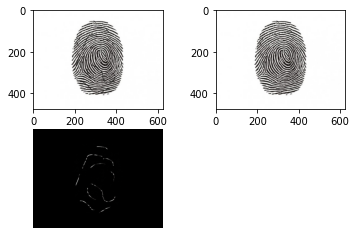

In [ ]:
print("Detalhe visual das digitais e comparando suas diferenças")

plt.subplot(2, 2, 1)
plt.imshow(biomChops)

plt.subplot(2, 2, 2)
plt.imshow(biom_sisChops)

plt.subplot(2, 2, 3)
plt.imshow(diff)

plt.axis("off")
plt.show()

In [ ]:
print("Diferença detectada nas Imagens: ", diff_md,"%")
if diff_md < 0.005:
  risco += 10
elif diff_md >= 0.005 and diff_md < 0.05:
  risco += 15
elif diff_md >= 0.05 and diff_md < 0.5:
  risco += 20
else:
  risco += 40

Diferença detectada nas Imagens:  0.003781158324152205 %


In [ ]:
print("Risco total calculado:",risco, "%")
print("Diferença das digitais aproximadamente %.5f"%diff_md,"%")
print(msg)

Risco total calculado: 10 %
Diferença das digitais aproximadamente 0.00378 %
O Destinatario e Recebedor são os mesmos


#Limpando imagens da memória

In [ ]:
#Apagando arquivos
try:
  os.remove("./ass_zip.zip")
  os.remove("./bio_zip.zip")

  os.remove("./assinatura_filtrada.png")

  os.remove(bi)
  os.remove(bi_s)
  os.remove("./Imagens/" + ass)

  os.rmdir("./Imagens")
except:
  print("Erro ao apagar arquivos")